In [55]:
%pip install pandas numpy scikit-learn xgboost matplotlib seaborn holidays

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import holidays
import itertools
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

In [57]:
# --- Step 1: Data Loading and Initial Preprocessing  ---

df = pd.read_excel("Hotel_Revenue_Data.xlsx")


df['Date'] = pd.to_datetime(df['Date'])
df['CheckTotal'] = pd.to_numeric(df['CheckTotal'], errors='coerce')
df = df.dropna(subset=['CheckTotal'])

# Filter out RevenueCenter_4 and negative/zero values as per your logic
df = df[df["RevenueCenterName"] != "RevenueCenter_4"]
df = df[df["CheckTotal"] >= 0]

# Group data by date, meal period, and revenue center
grouped = df.groupby(['Date', 'MealPeriod', 'RevenueCenterName'])['CheckTotal'].sum().reset_index()

In [58]:
# --- Step 2: Feature Engineering ---

# Function to add all time-related features
def add_time_features(data):
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    data['Day'] = data['Date'].dt.day
    data['Month'] = data['Date'].dt.month
    data['Year'] = data['Date'].dt.year
    data['Week'] = data['Date'].dt.isocalendar().week.astype(int)
    data['DayOfYear'] = data['Date'].dt.dayofyear
    return data

grouped = add_time_features(grouped)

In [59]:
# Add UAE holidays as a feature
# The correct way to use the holidays library is country_holidays('country_code')
uae_holidays = holidays.country_holidays('AE', years=range(2023, 2025))
grouped['is_holiday'] = grouped['Date'].apply(lambda x: 1 if x in uae_holidays else 0)

In [60]:
'''
# --- Step 4: Model Training and Forecasting ---

# Main function to train, evaluate, and forecast with XGBoost
def train_and_forecast_xgboost(data, group_by_col):
    results = []
    forecasts = {}

    # Define features and target
    features = ['DayOfWeek', 'Day', 'Month', 'Year', 'Week', 'DayOfYear', 'is_holiday']
    target = 'CheckTotal'

    # Encode categorical features for XGBoost
    le_rev = LabelEncoder()
    data['RevenueCenterEncoded'] = le_rev.fit_transform(data['RevenueCenterName'])
    features.append('RevenueCenterEncoded')

    le_meal = LabelEncoder()
    data['MealPeriodEncoded'] = le_meal.fit_transform(data['MealPeriod'])
    features.append('MealPeriodEncoded')

    for group_name, group_df in data.groupby(group_by_col):
        if group_df.empty or len(group_df) < 60:
            continue

        # Split data into training and validation sets
        # Use the last 30 days for validation
        train_df = group_df[group_df['Date'] < group_df['Date'].max() - timedelta(days=30)].copy()
        val_df = group_df[group_df['Date'] >= group_df['Date'].max() - timedelta(days=30)].copy()

        X_train, y_train = train_df[features], train_df[target]
        X_val, y_val = val_df[features], val_df[target]

        # Initialize and train the XGBoost Regressor
        model = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=1000,
                                 learning_rate=0.05,
                                 max_depth=5,
                                 subsample=0.7,
                                 colsample_bytree=0.7,
                                 tree_method='hist', # Use 'hist' for faster training
                                 enable_categorical=True, # Modern XGBoost can handle categorical data directly
                                 early_stopping_rounds=50)

        # Train the model
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        # --- Evaluation on validation set ---
        val_preds = model.predict(X_val)
        val_preds[val_preds < 0] = 0 # Ensure predictions are non-negative

        rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        mae = mean_absolute_error(y_val, val_preds)
        mape = np.mean(np.abs((y_val - val_preds) / y_val)) * 100 if np.mean(y_val) != 0 else np.nan

        results.append({
            'Group': group_name,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape
        })

        # --- Forecasting future dates (Next 3 months or 90 days) ---
        last_date = group_df['Date'].max()
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=90, freq='D')

        # Create a dataframe for future predictions
        future_df = pd.DataFrame({'Date': future_dates})

        # Create features for the future dates
        future_df = add_time_features(future_df)
        future_df['is_holiday'] = future_df['Date'].apply(lambda x: 1 if x in uae_holidays else 0)

        # Add encoded categorical features, they will be constant for each group
        future_df['RevenueCenterEncoded'] = le_rev.transform([group_name[1]]) if isinstance(group_name, tuple) else le_rev.transform([group_name])
        future_df['MealPeriodEncoded'] = le_meal.transform([group_name[0]]) if isinstance(group_name, tuple) else None

        # Predict future revenue
        future_preds = model.predict(future_df[features])
        future_preds[future_preds < 0] = 0

        future_df['Forecast'] = future_preds
        forecasts[group_name] = future_df

        # --- Visualization of training and forecast ---
        plt.figure(figsize=(14, 7))
        plt.plot(train_df['Date'], train_df['CheckTotal'], label='Training Data', color='blue')
        plt.plot(val_df['Date'], val_df['CheckTotal'], label='Validation Data', color='green')
        plt.plot(val_df['Date'], val_preds, label='Validation Predictions', color='orange', linestyle='--')
        plt.plot(future_df['Date'], future_df['Forecast'], label='90-Day Forecast', color='red', linestyle=':')

        plt.title(f'XGBoost Forecast for {group_name}', fontsize=16)
        plt.xlabel('Date')
        plt.ylabel('Total Check Revenue')
        plt.legend()
        plt.grid(True)
        plt.show()

    return pd.DataFrame(results), forecasts
    '''

"\n# --- Step 4: Model Training and Forecasting ---\n\n# Main function to train, evaluate, and forecast with XGBoost\ndef train_and_forecast_xgboost(data, group_by_col):\n    results = []\n    forecasts = {}\n\n    # Define features and target\n    features = ['DayOfWeek', 'Day', 'Month', 'Year', 'Week', 'DayOfYear', 'is_holiday']\n    target = 'CheckTotal'\n\n    # Encode categorical features for XGBoost\n    le_rev = LabelEncoder()\n    data['RevenueCenterEncoded'] = le_rev.fit_transform(data['RevenueCenterName'])\n    features.append('RevenueCenterEncoded')\n\n    le_meal = LabelEncoder()\n    data['MealPeriodEncoded'] = le_meal.fit_transform(data['MealPeriod'])\n    features.append('MealPeriodEncoded')\n\n    for group_name, group_df in data.groupby(group_by_col):\n        if group_df.empty or len(group_df) < 60:\n            continue\n\n        # Split data into training and validation sets\n        # Use the last 30 days for validation\n        train_df = group_df[group_df['Date'

In [61]:
def remove_outliers_iqr_with_zero_min(df):
    cleaned_data = []

    # Group by MealPeriod and RevenueCenterName
    grouped = df.groupby(['MealPeriod', 'RevenueCenterName'])

    for (meal, center), group in grouped:
        q1 = group['CheckTotal'].quantile(0.25)
        q3 = group['CheckTotal'].quantile(0.75)
        iqr = q3 - q1

        # IQR bounds
        lower_bound = max(q1 - 1.5 * iqr, 0)  # Enforce minimum of 0
        upper_bound = q3 + 1.5 * iqr

        # Filter within bounds
        filtered = group[(group['CheckTotal'] >= lower_bound) & (group['CheckTotal'] <= upper_bound)]
        cleaned_data.append(filtered)

    # Concatenate all filtered groups
    return pd.concat(cleaned_data).reset_index(drop=True)

# Apply the updated function
grouped = remove_outliers_iqr_with_zero_min(grouped)


--- Forecasting by (MealPeriod, RevenueCenter) ---


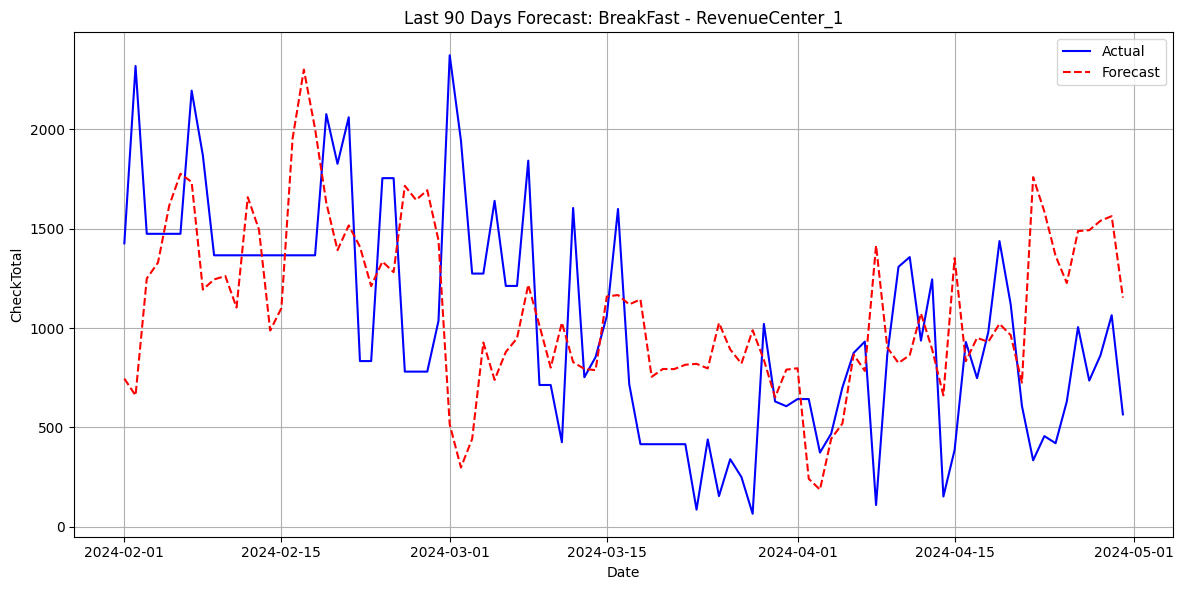

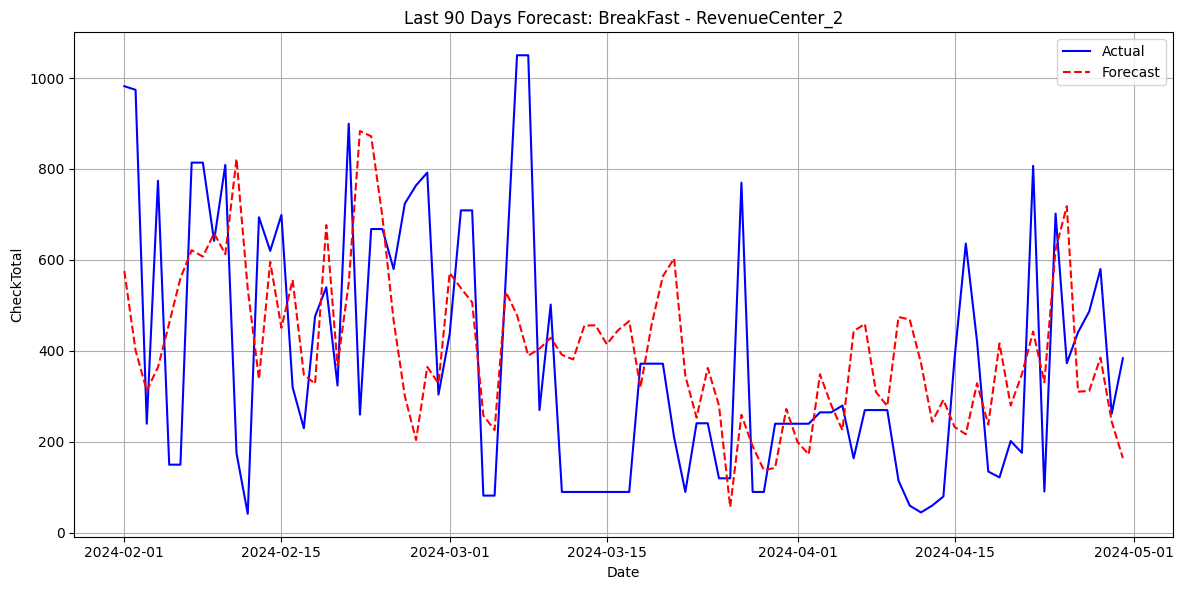

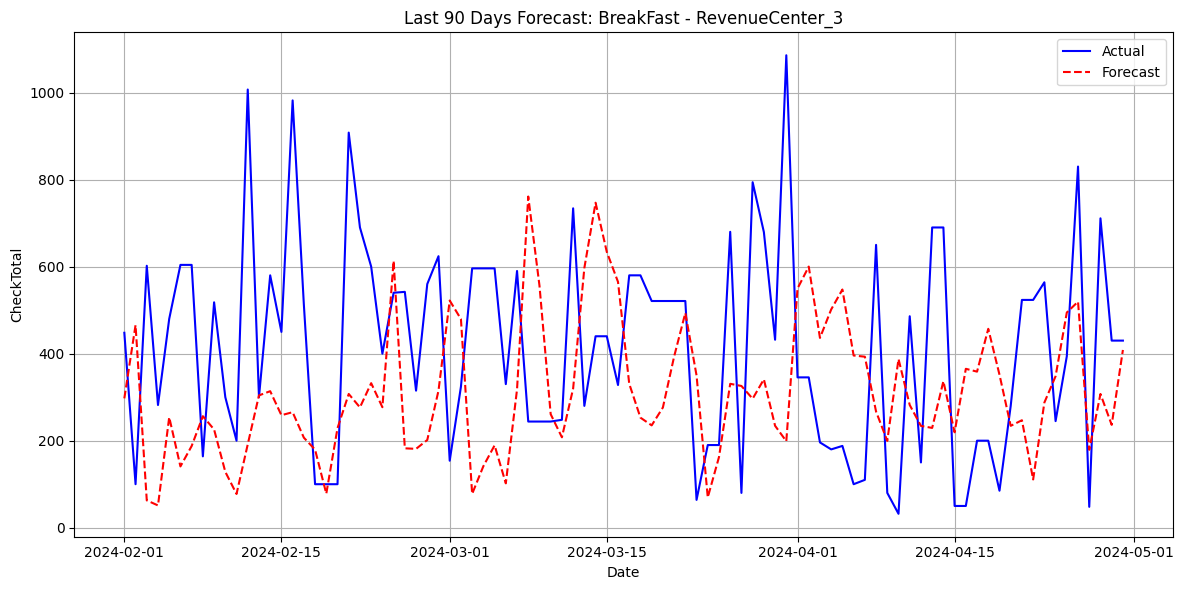

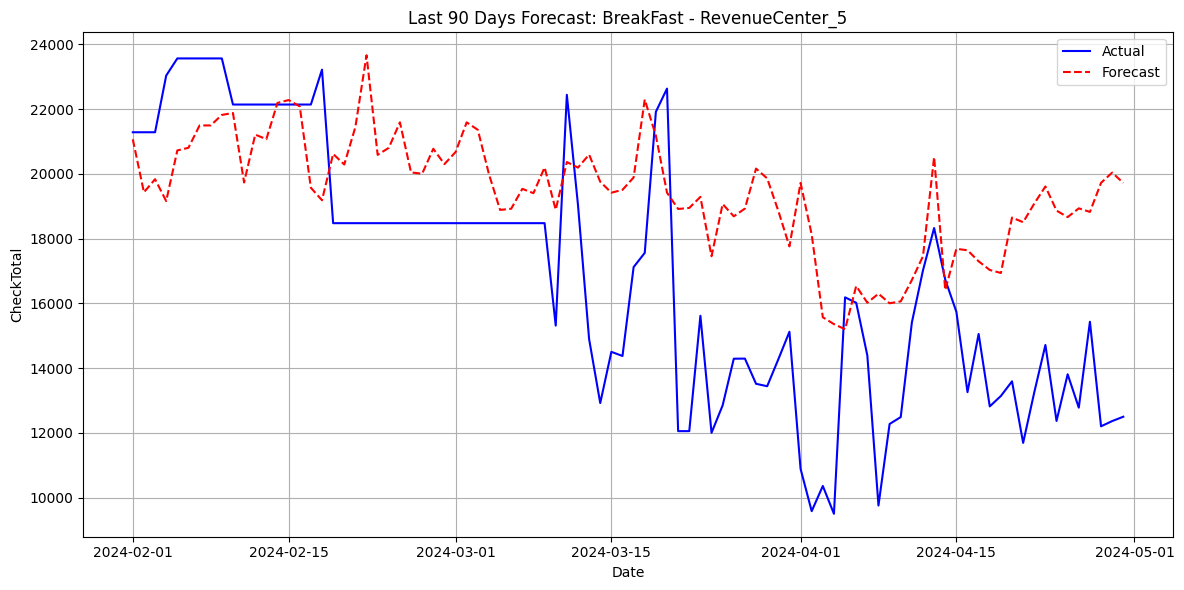

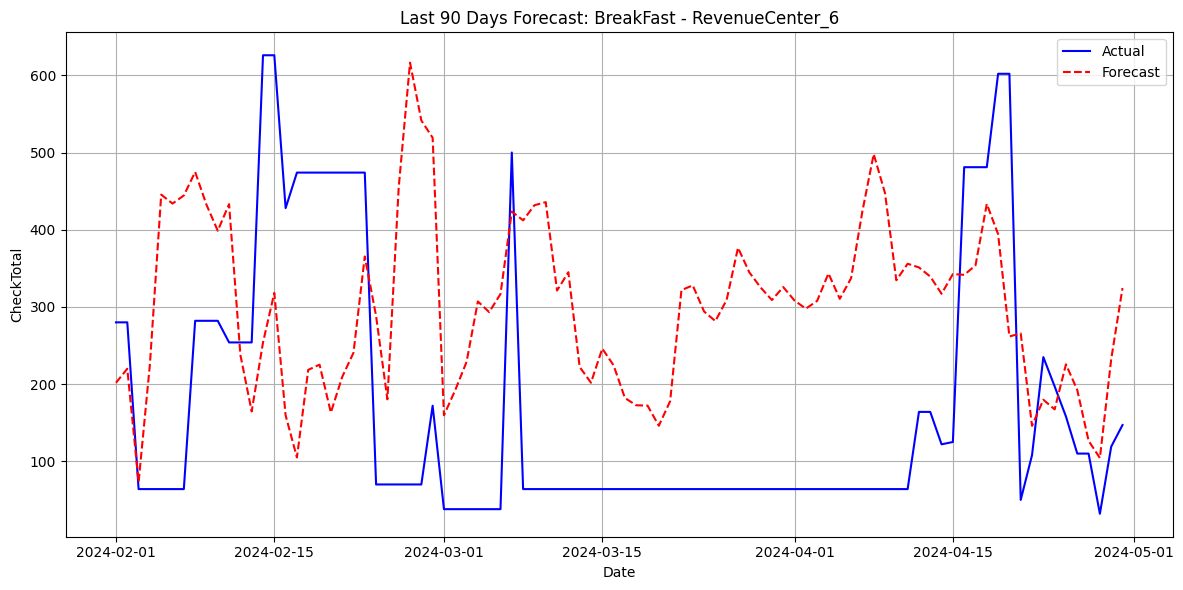

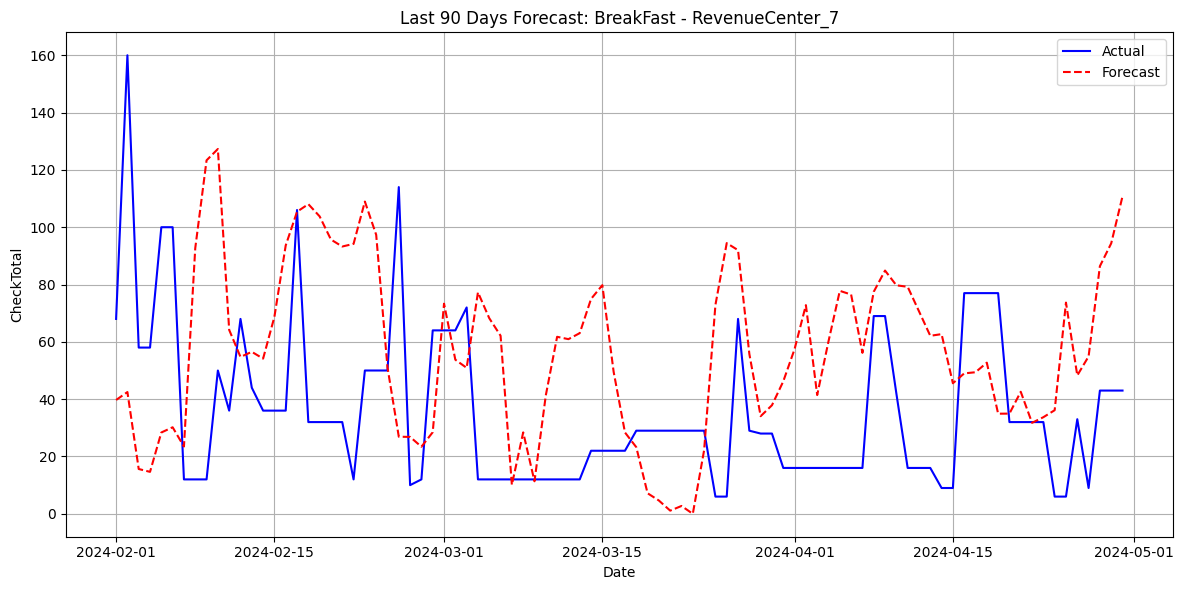

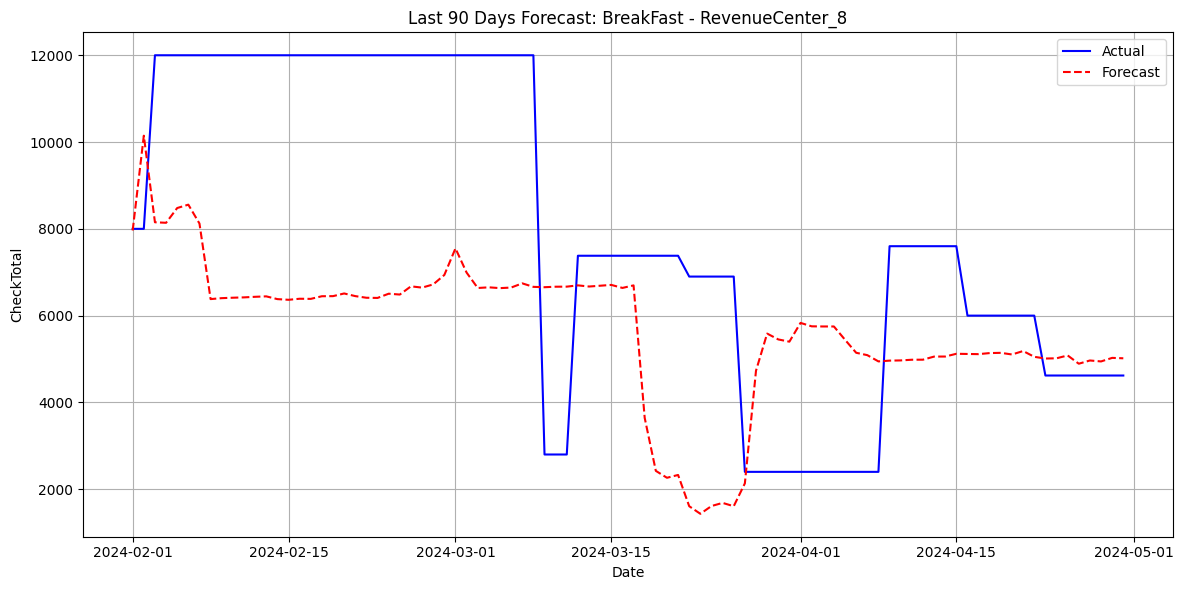

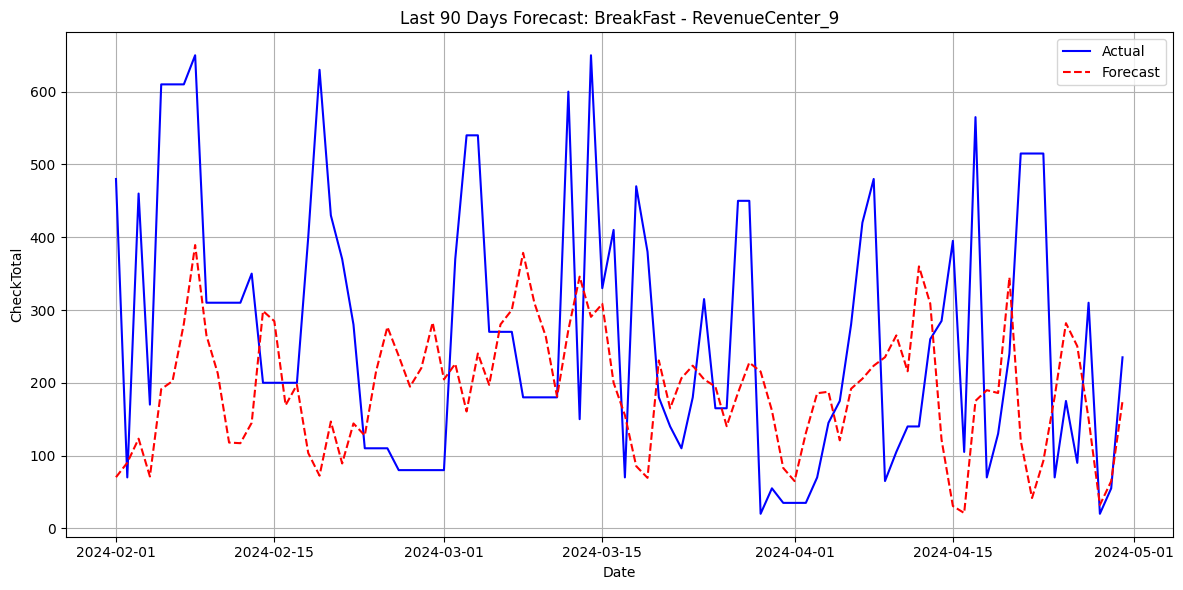

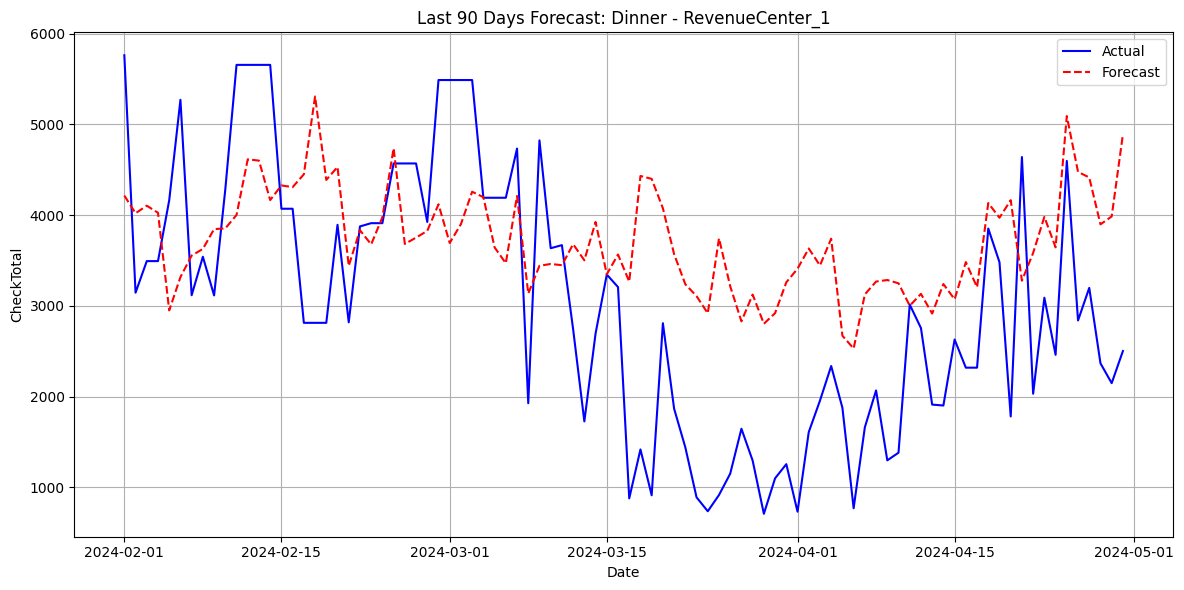

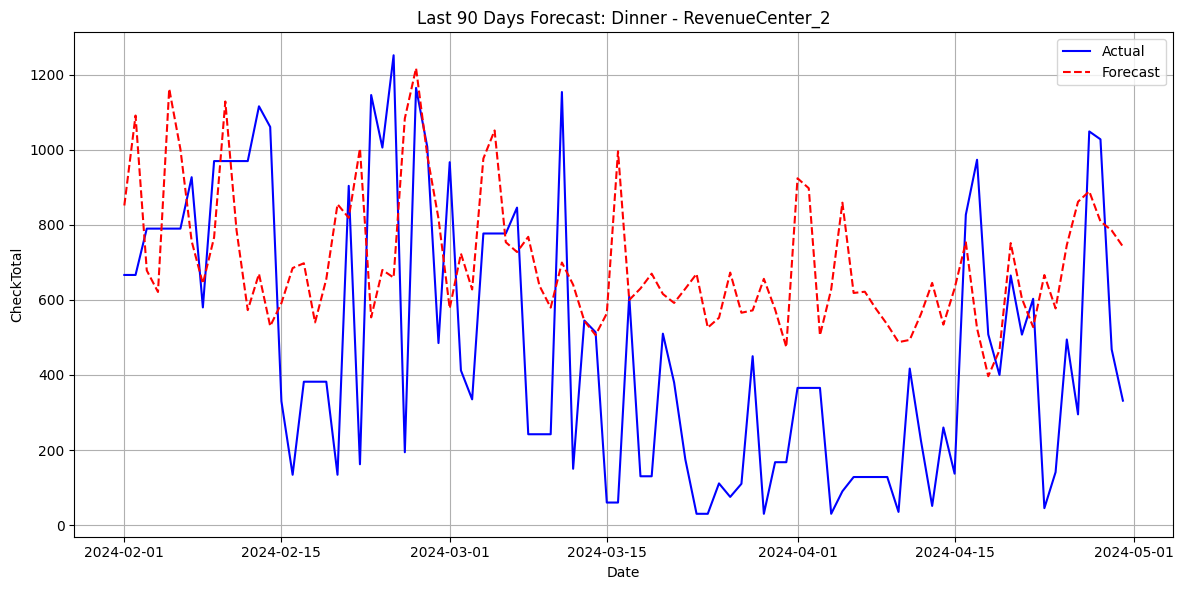

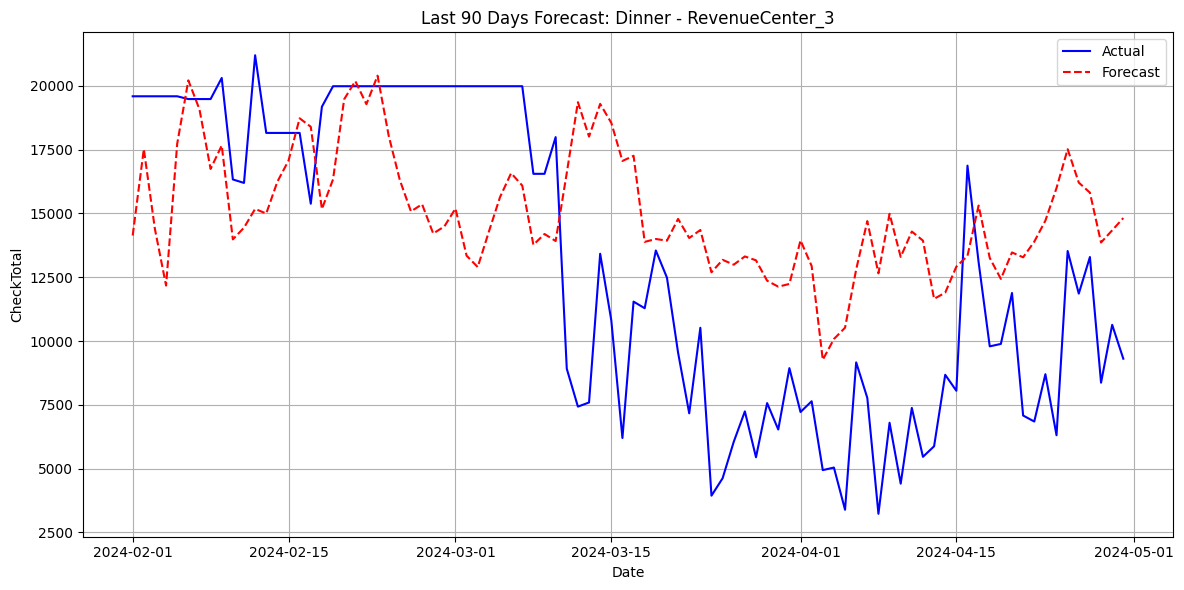

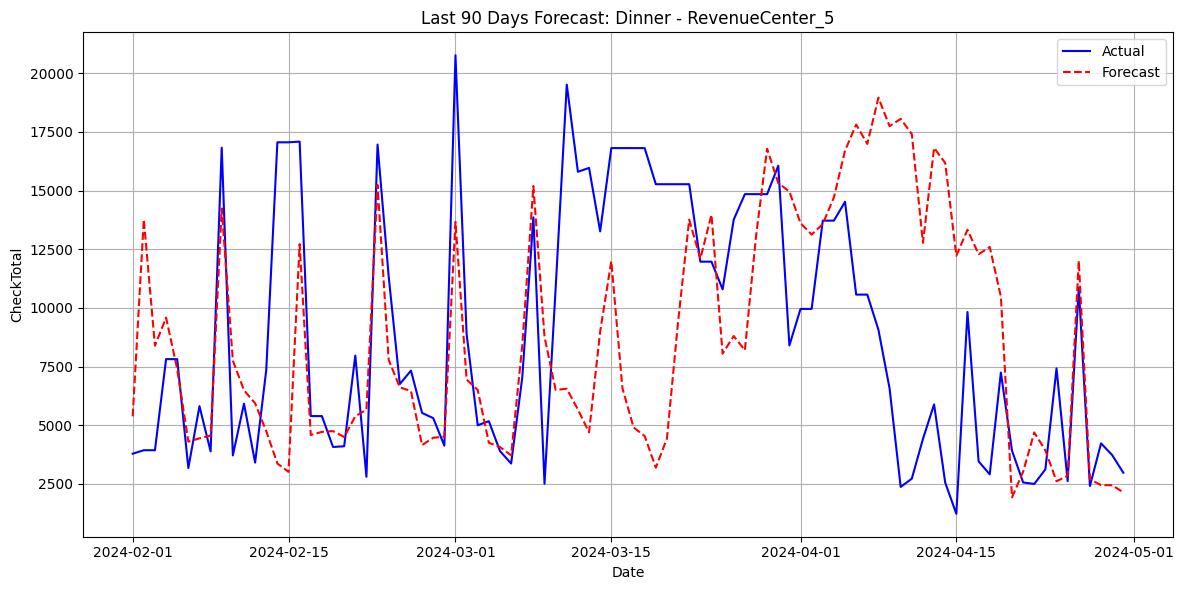

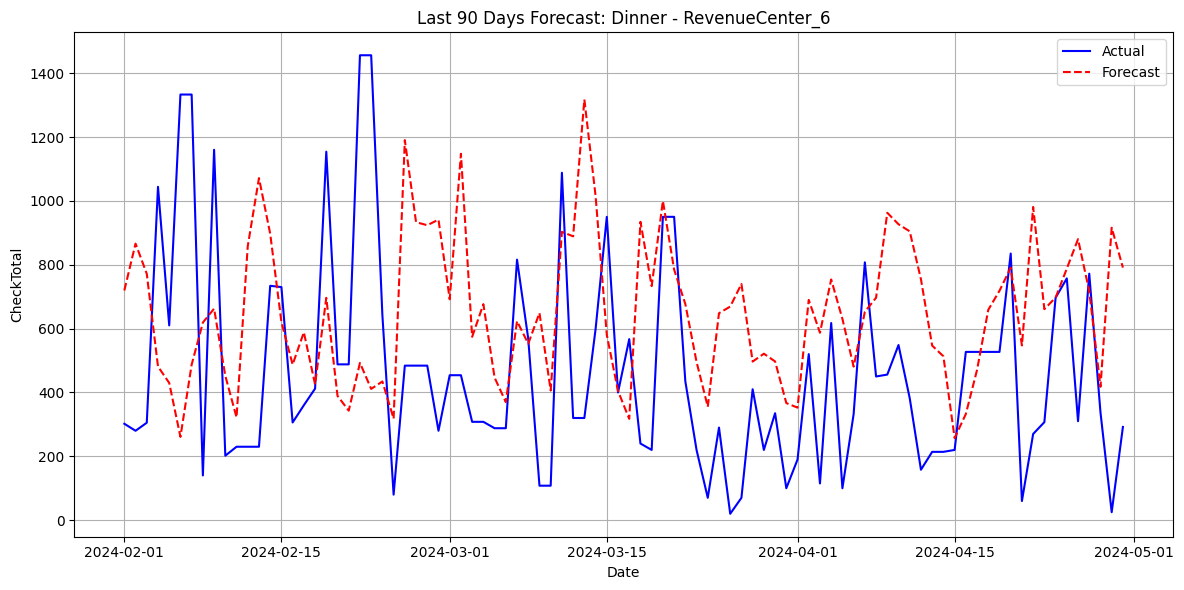

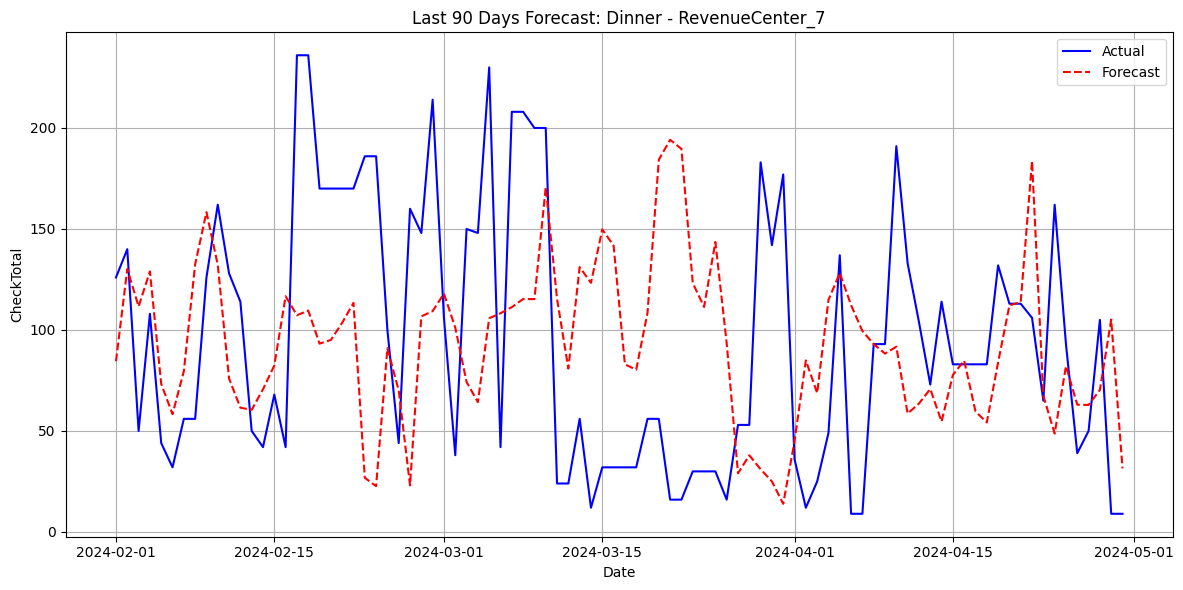

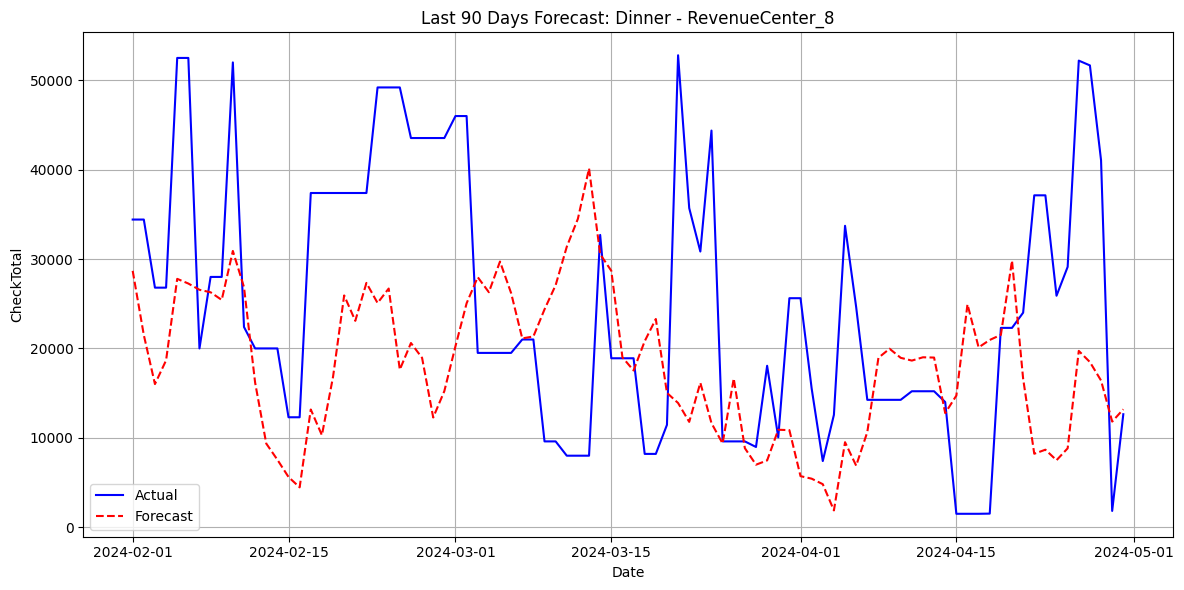

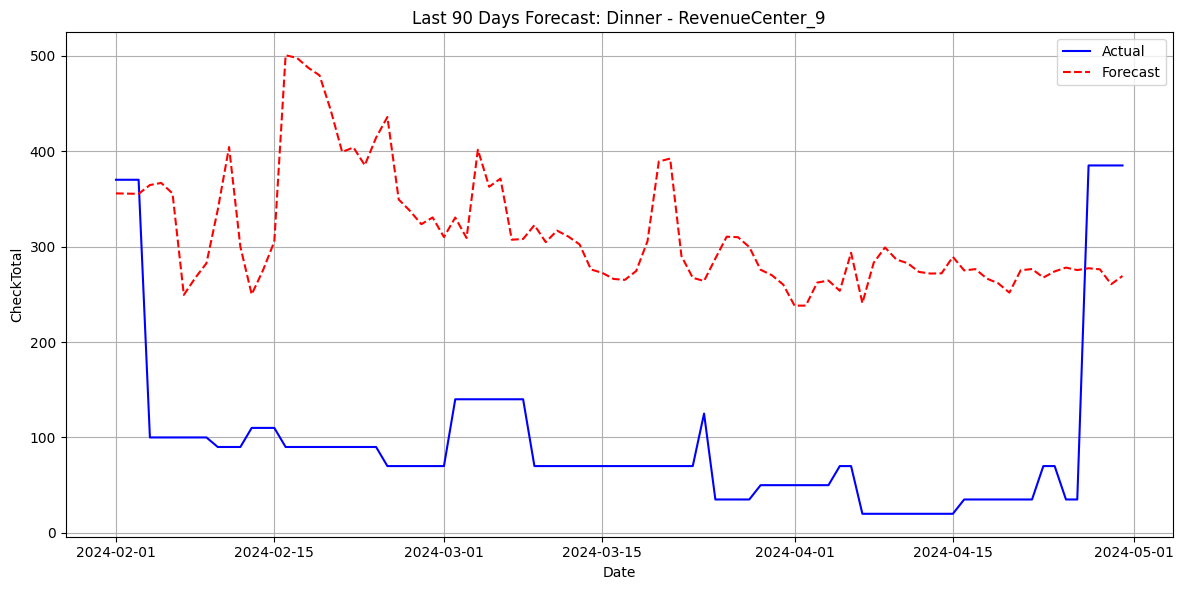

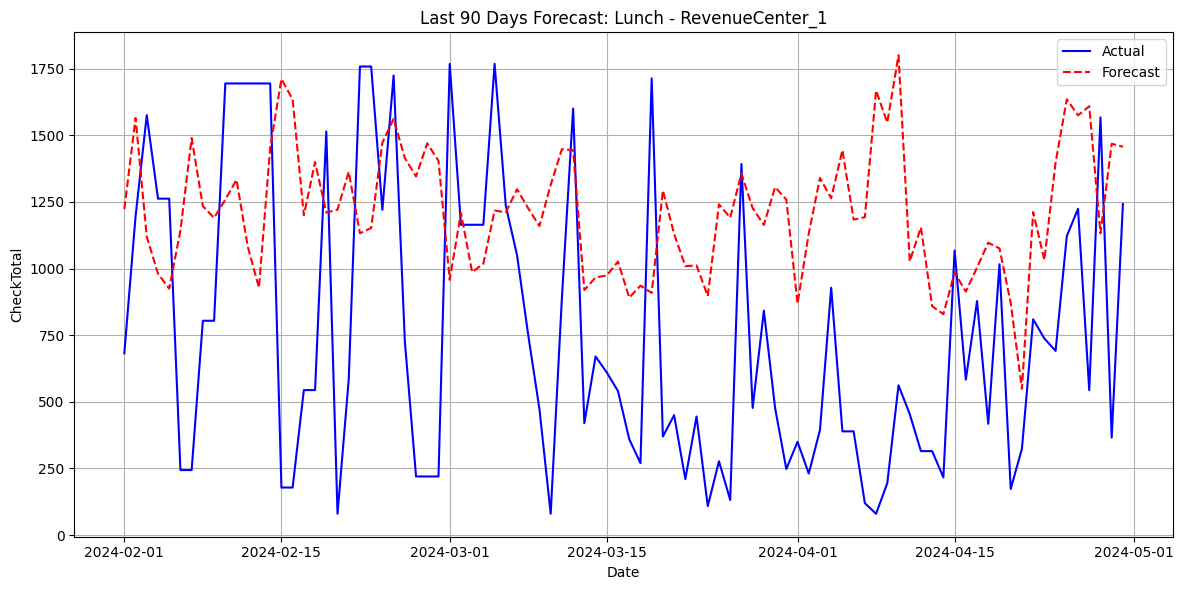

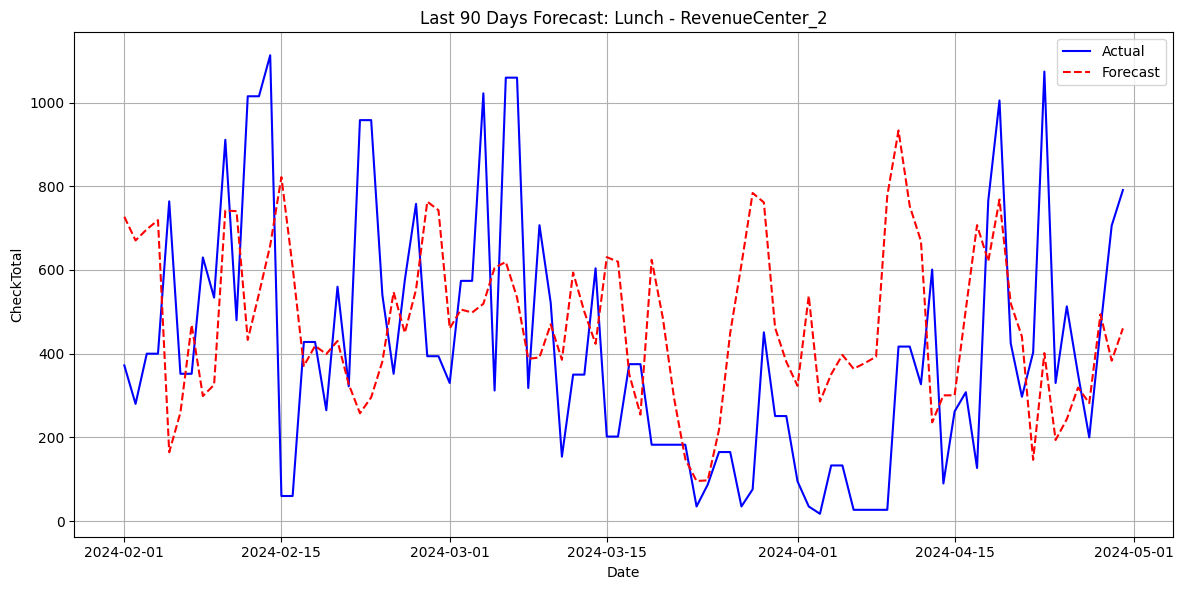

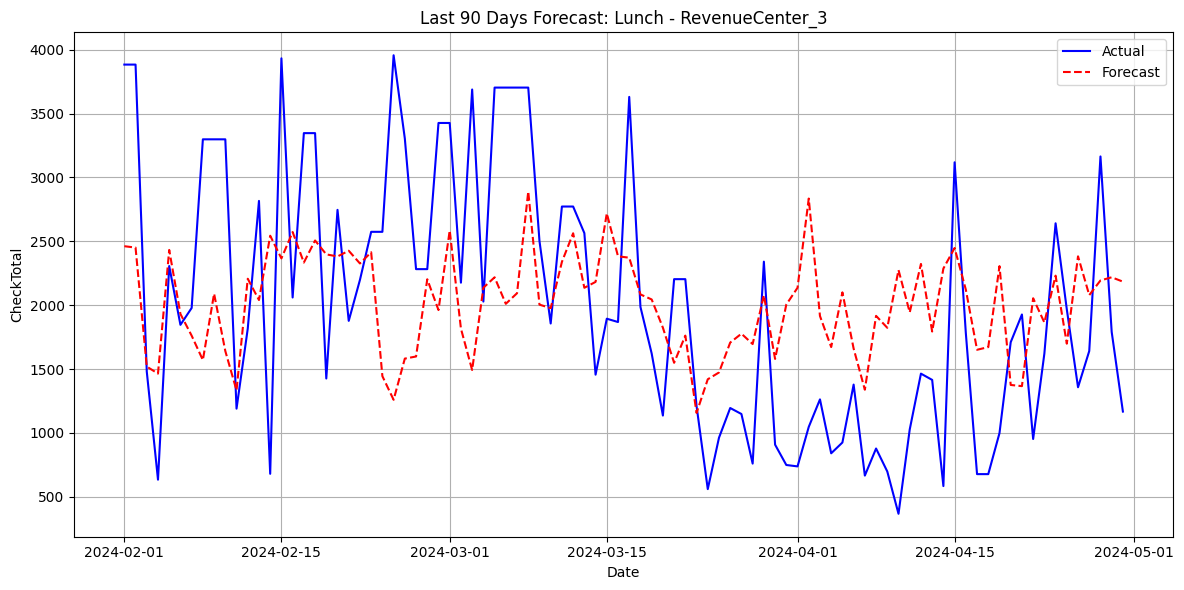

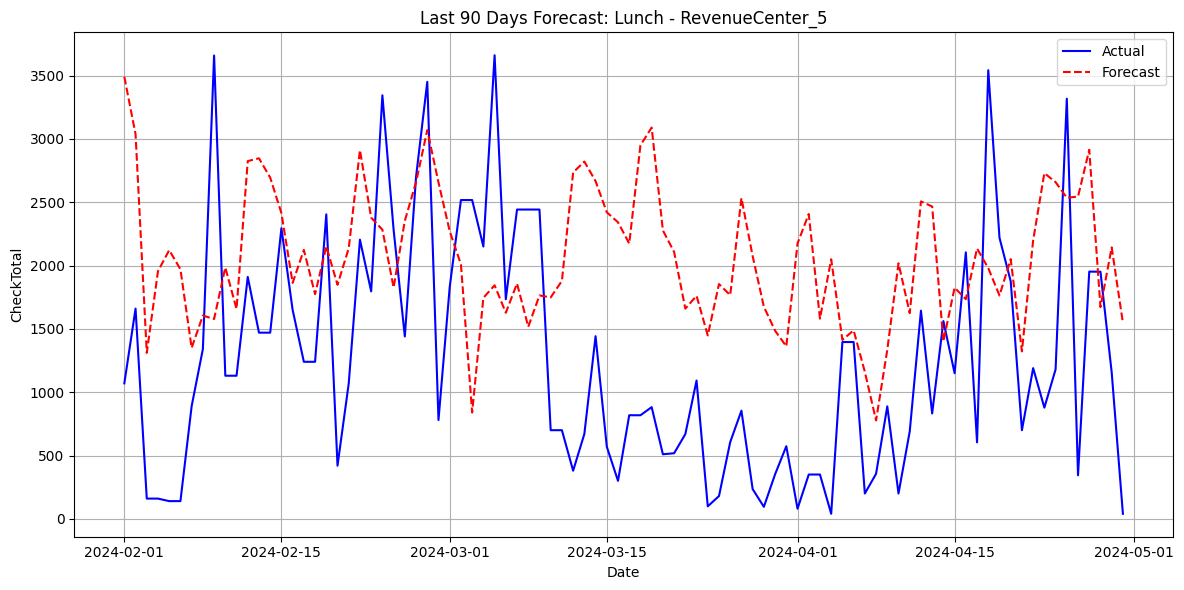

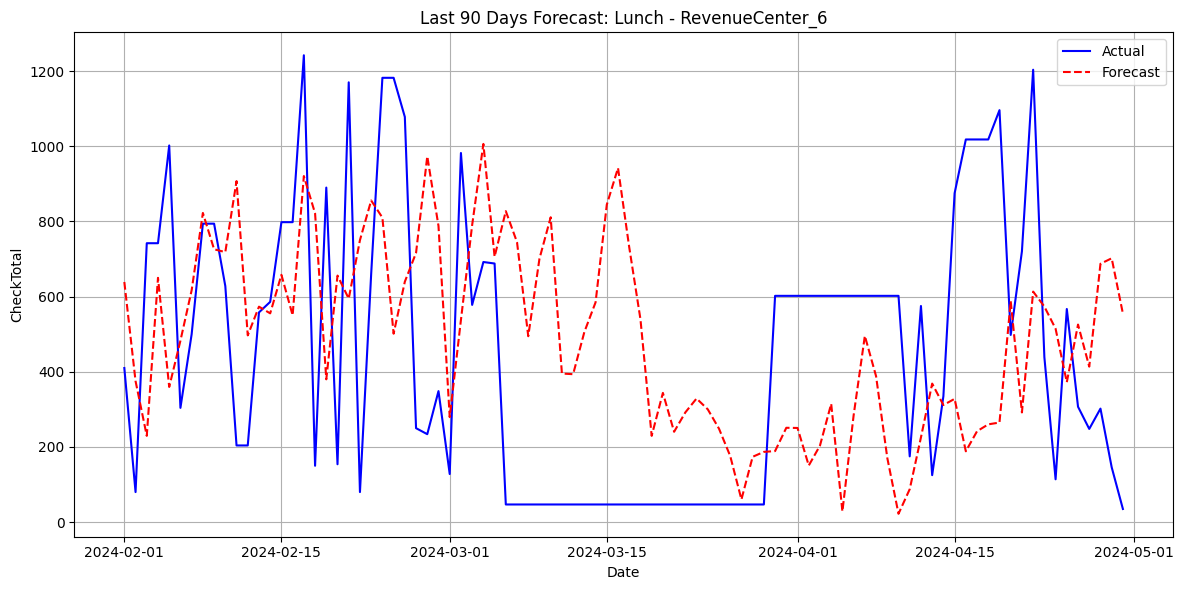

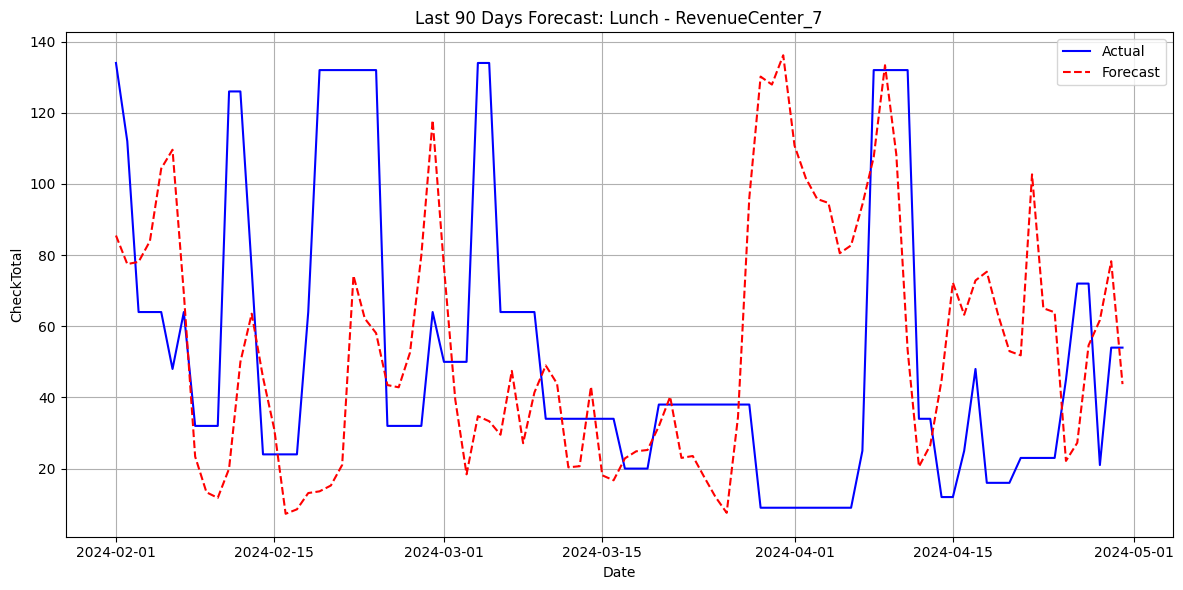

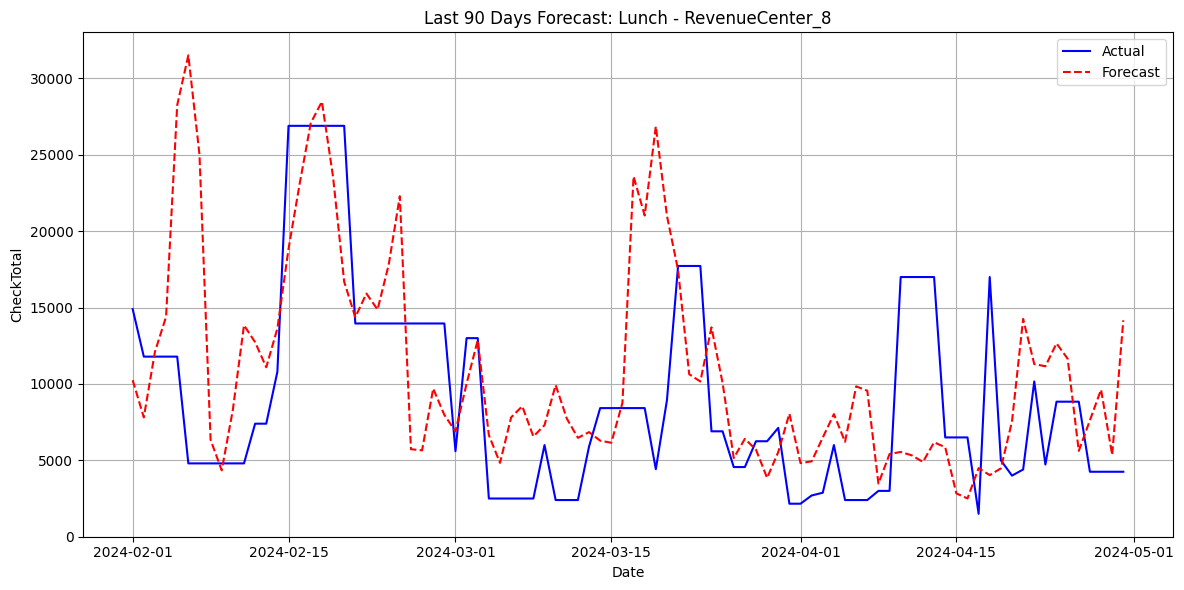

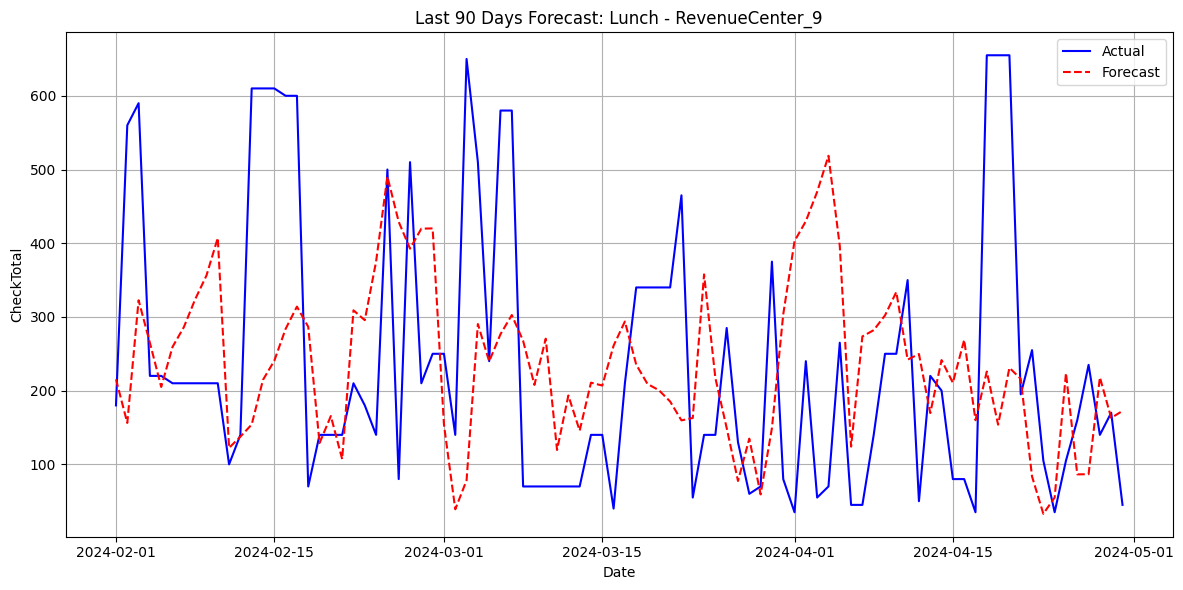


Evaluation Metrics for (MealPeriod, RevenueCenter) Forecast:
                          Group          RMSE           MAE        MAPE
0   BreakFast - RevenueCenter_1    619.552514    490.128489  103.062977
1   BreakFast - RevenueCenter_2    278.885720    223.938047  125.640571
2   BreakFast - RevenueCenter_3    319.927284    273.003881  106.203074
3   BreakFast - RevenueCenter_5   4042.744217   3366.442025   23.840589
4   BreakFast - RevenueCenter_6    244.153033    216.515478  269.087079
5   BreakFast - RevenueCenter_7     46.732758     38.721804  211.885008
6   BreakFast - RevenueCenter_8   3945.713438   3425.488199   50.767147
7   BreakFast - RevenueCenter_9    211.359028    167.085130   85.995358
8      Dinner - RevenueCenter_1   1441.992344   1216.612075   70.014395
9      Dinner - RevenueCenter_2    410.530825    349.194871  283.233323
10     Dinner - RevenueCenter_3   5400.382812   4718.881089   56.384385
11     Dinner - RevenueCenter_5   6258.614217   4485.840997   79.107316
12

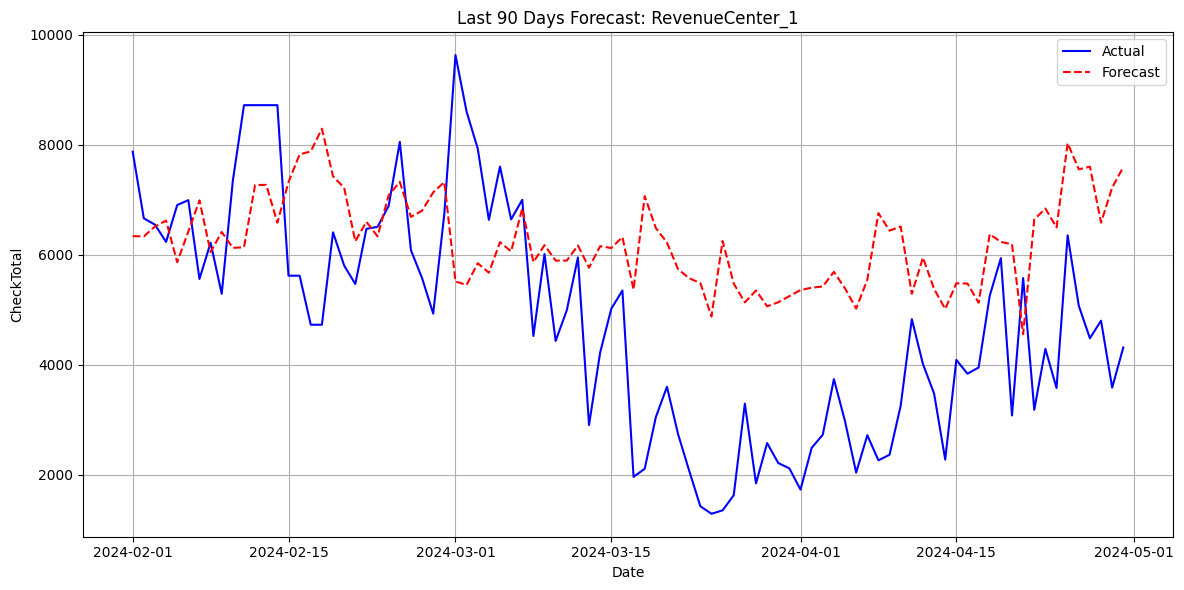

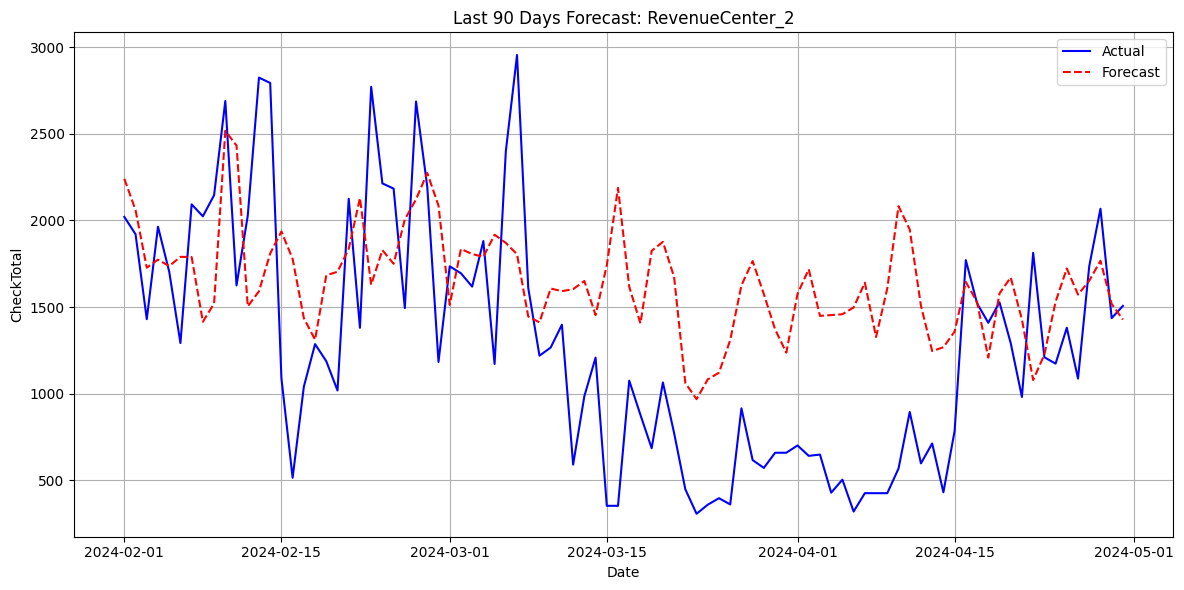

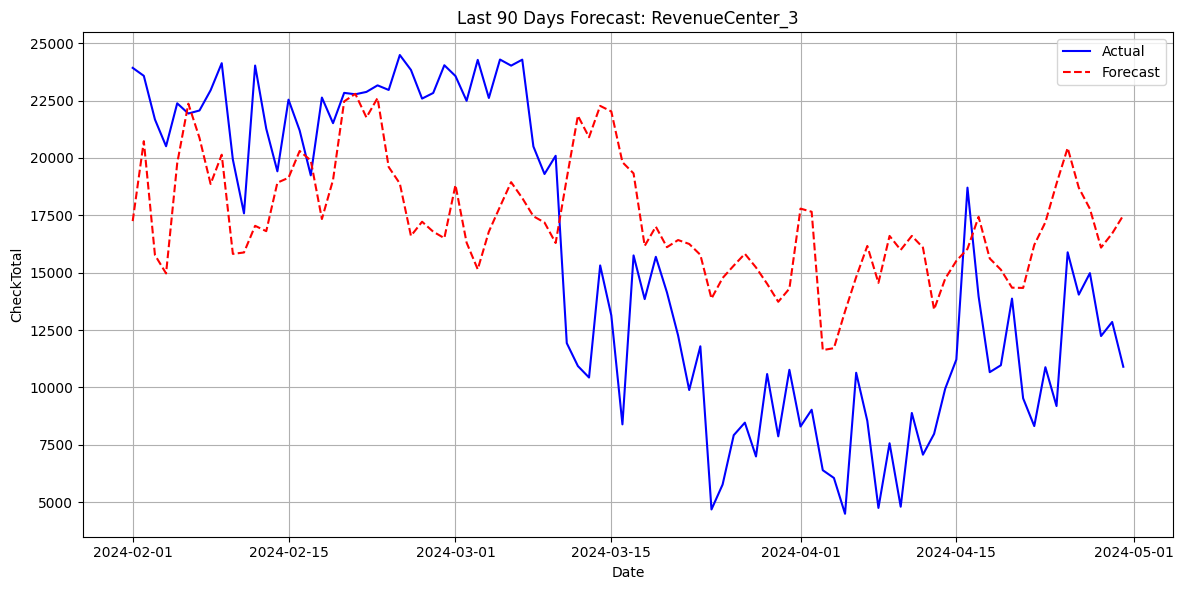

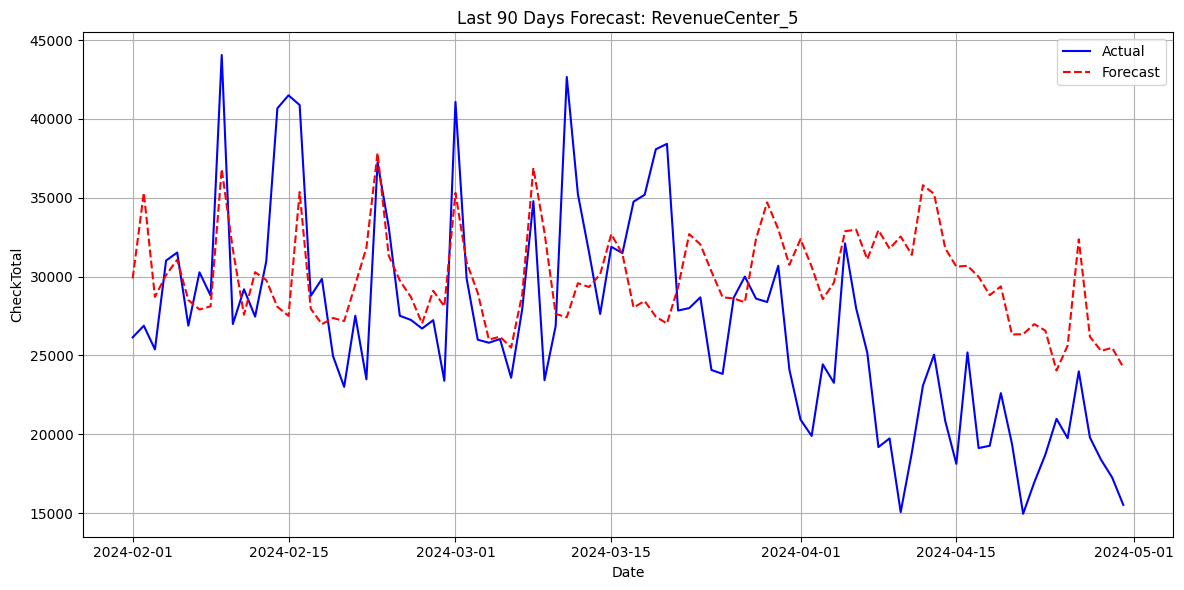

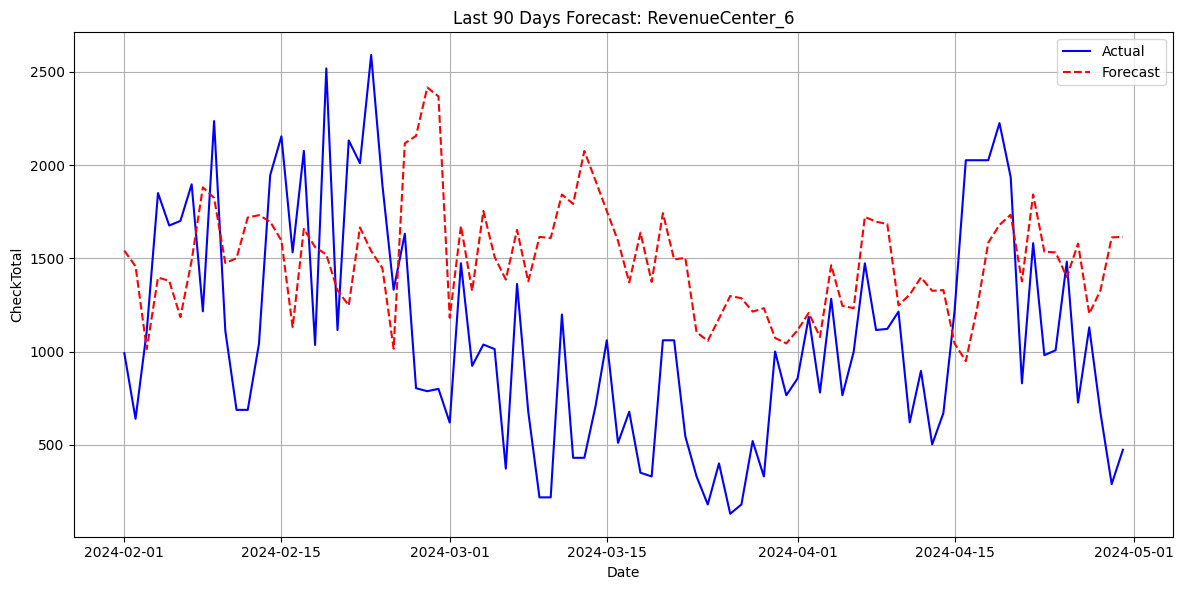

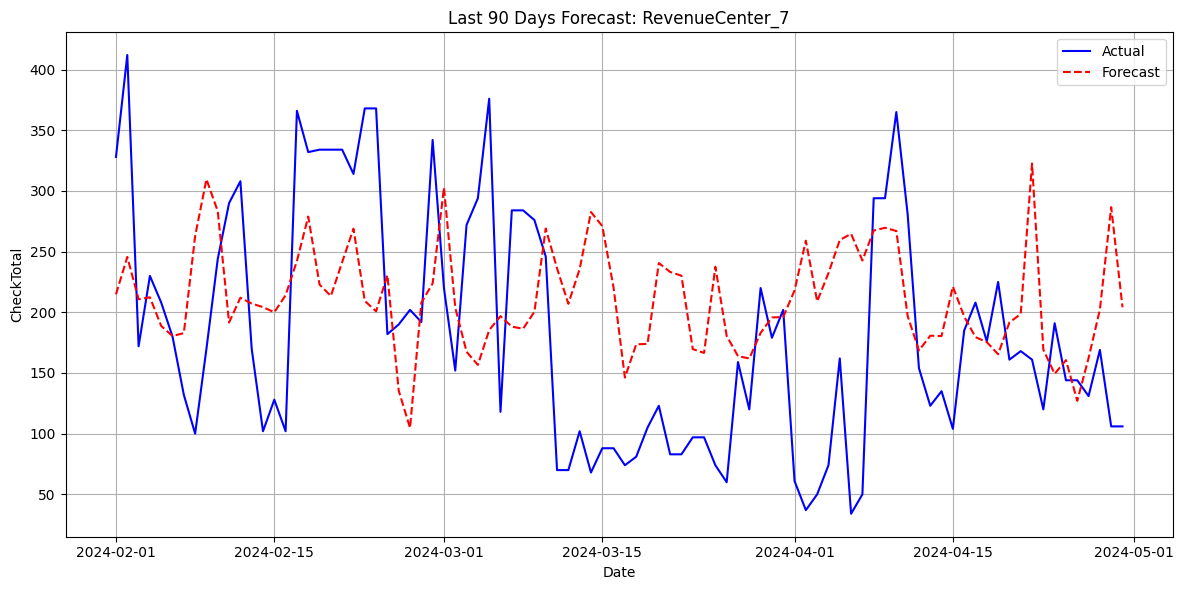

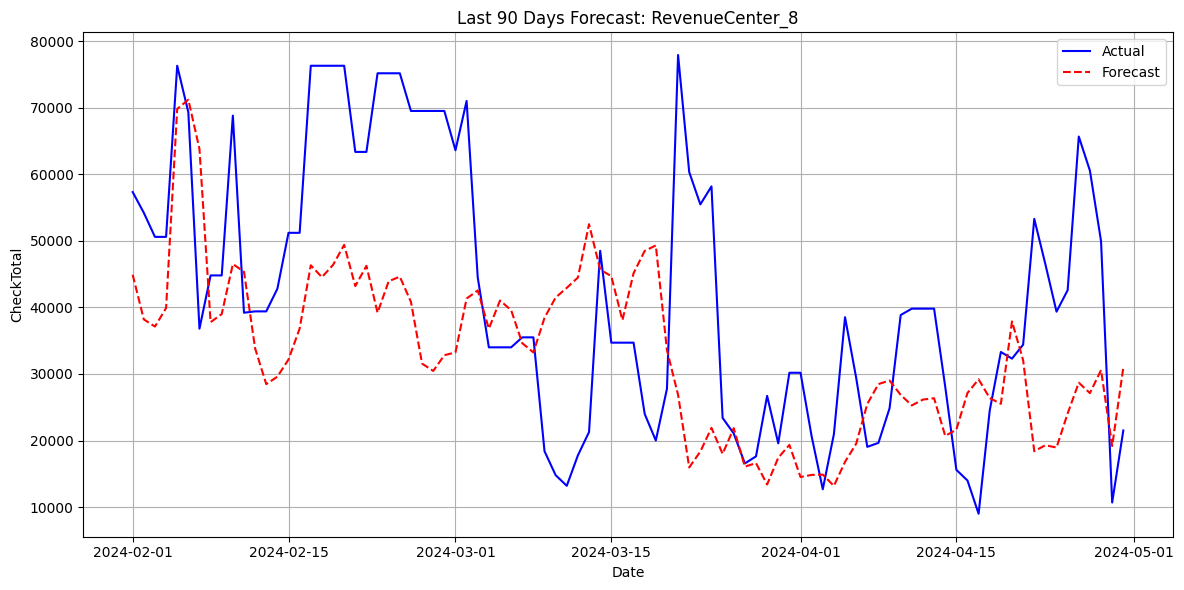

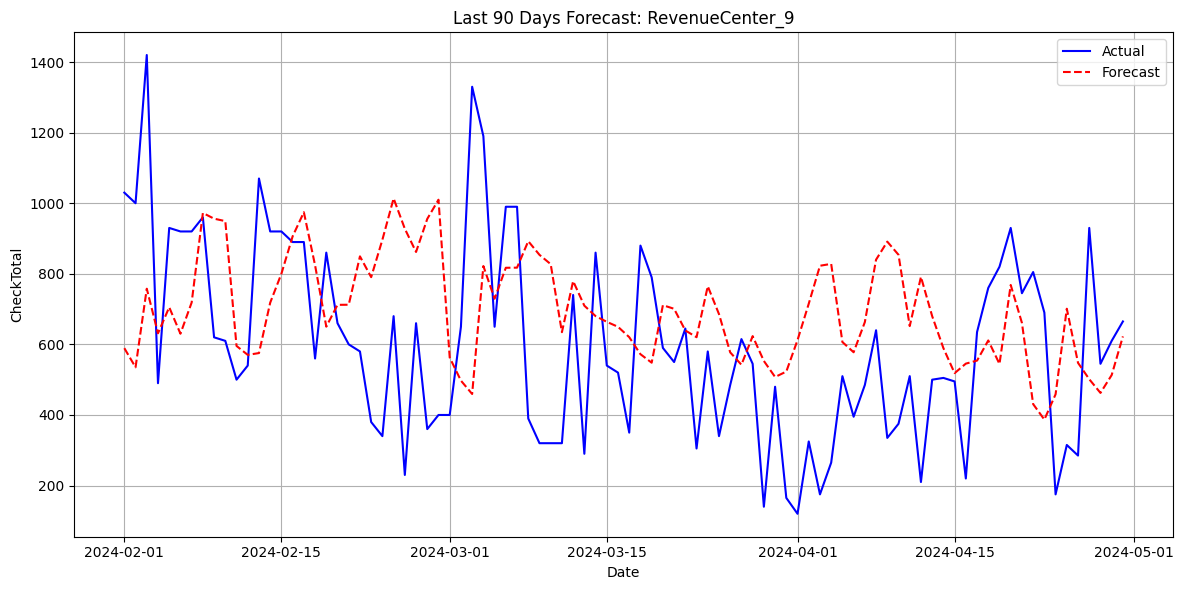


Evaluation Metrics for Daily Total Revenue per RevenueCenter:
             Group          RMSE           MAE        MAPE
0  RevenueCenter_1   2386.590412   2029.322490   67.077767
1  RevenueCenter_2    725.931001    606.695862   85.961592
2  RevenueCenter_3   5923.562166   5210.095211   49.406310
3  RevenueCenter_5   6951.980739   5515.825200   23.451950
4  RevenueCenter_6    761.945147    654.396722  119.154687
5  RevenueCenter_7    106.549817     89.279844   83.510155
6  RevenueCenter_8  20744.919199  16680.756489   44.863536
7  RevenueCenter_9    329.559190    270.202717   69.485514

--- Correlation Matrix of Features ---


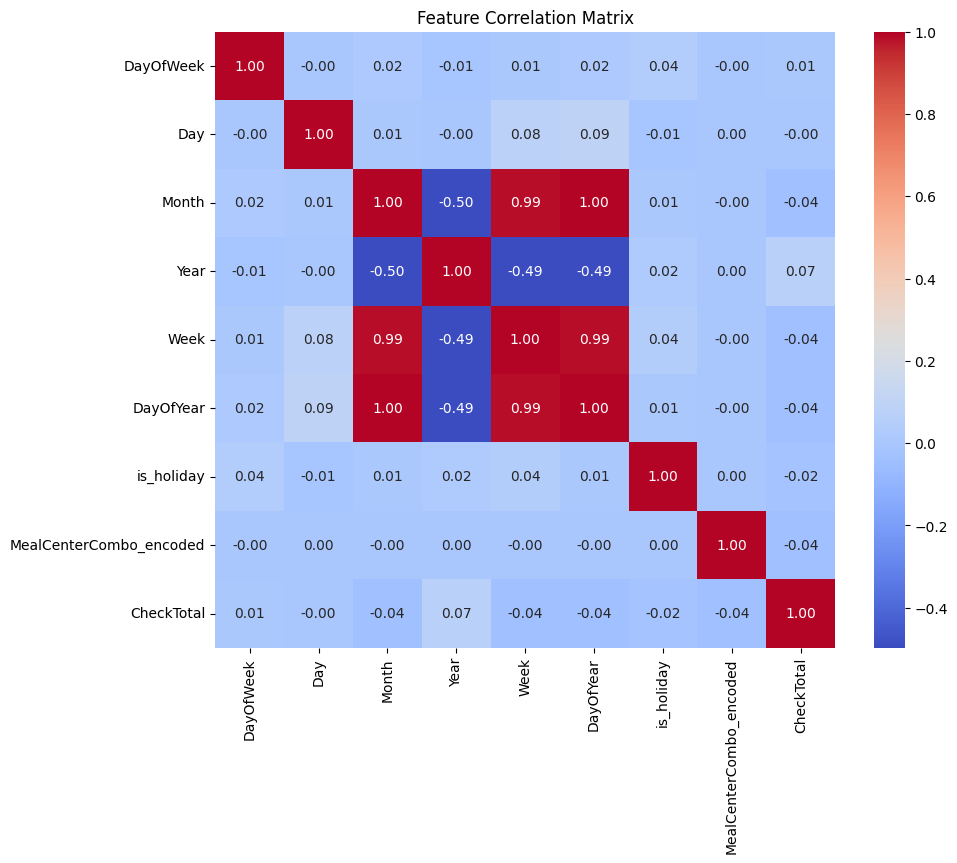

In [62]:
# Step 1: Create complete date range and combinations
date_range = pd.date_range(start=grouped['Date'].min(), end=grouped['Date'].max(), freq='D')
revenue_centers = grouped['RevenueCenterName'].unique()
meal_periods = grouped['MealPeriod'].unique()

# Step 2: Create full combination of Date x MealPeriod x RevenueCenterName
full_combinations = pd.DataFrame(
    list(itertools.product(date_range, meal_periods, revenue_centers)),
    columns=['Date', 'MealPeriod', 'RevenueCenterName']
)

# Step 3: Merge with original data (left join)
full_data = full_combinations.merge(grouped, on=['Date', 'MealPeriod', 'RevenueCenterName'], how='left')

# Step 4: Fill missing CheckTotal with 0 temporarily (assume no sales on missing days)
full_data['CheckTotal'] = full_data['CheckTotal'].fillna(0)

# Step 5: Sort data before interpolation (important!)
full_data.sort_values(by=['RevenueCenterName', 'MealPeriod', 'Date'], inplace=True)

# Step 6: Interpolate CheckTotal for each RevenueCenter and MealPeriod group
full_data['CheckTotal'] = (
    full_data.groupby(['RevenueCenterName', 'MealPeriod'])['CheckTotal']
    .transform(lambda x: x.replace(0, pd.NA)
                         .interpolate(method='linear')
                         .fillna(method='bfill')
                         .fillna(method='ffill')
                         .fillna(0))
)


# Step 7: Add time features and holiday flag
full_data = add_time_features(full_data)
full_data['is_holiday'] = full_data['Date'].apply(lambda x: 1 if x in uae_holidays else 0)










# --- Step 4: Refactored Forecasting Function ---
def train_and_forecast_xgboost(data, group_by_col, features, target_col):
    results = []
    all_preds = []

    for group_name, group_df in data.groupby(group_by_col):
        group_df = group_df.sort_values('Date')
        if len(group_df) < 120:
            continue

        train_df = group_df.iloc[:-90].copy()
        test_df = group_df.iloc[-90:].copy()

        X_train, y_train = train_df[features], train_df[target_col]
        X_test, y_test = test_df[features], test_df[target_col]

        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05,
                                 max_depth=5, subsample=0.7, colsample_bytree=0.7, tree_method='hist')
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        preds[preds < 0] = 0

        test_df['Forecast'] = preds
        test_df[group_by_col] = group_name
        all_preds.append(test_df)

        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        mape = np.mean(np.abs((y_test - preds) / y_test)) * 100 if np.mean(y_test) != 0 else np.nan

        results.append({'Group': group_name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape})

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(test_df['Date'], y_test, label='Actual', color='blue')
        plt.plot(test_df['Date'], preds, label='Forecast', color='red', linestyle='--')
        plt.title(f"Last 90 Days Forecast: {group_name}")
        plt.xlabel("Date")
        plt.ylabel("CheckTotal")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    result_df = pd.DataFrame(results)
    forecast_df = pd.concat(all_preds, ignore_index=True)
    return result_df, forecast_df


# --- Forecasting Task 1: Revenue by Meal Period and Revenue Center ---
print("--- Forecasting by (MealPeriod, RevenueCenter) ---")
df_combo = full_data.copy()
df_combo['MealCenterCombo'] = df_combo['MealPeriod'] + ' - ' + df_combo['RevenueCenterName']

# Pre-encode the combined feature before passing to the function
le_combo = LabelEncoder()
df_combo['MealCenterCombo_encoded'] = le_combo.fit_transform(df_combo['MealCenterCombo'])
features_combo = ['DayOfWeek', 'Day', 'Month', 'Year', 'Week', 'DayOfYear', 'is_holiday', 'MealCenterCombo_encoded']

results_combo, forecasts_combo = train_and_forecast_xgboost(
    df_combo, 'MealCenterCombo', features_combo, 'CheckTotal')
print("\nEvaluation Metrics for (MealPeriod, RevenueCenter) Forecast:")
print(results_combo)

# --- Forecasting Task 2: Total Revenue per day per Revenue Center ---
print("\n--- Forecasting Total Revenue per RevenueCenter per Day ---")
total_rev_per_center = full_data.groupby(['Date', 'RevenueCenterName']).agg({
    'CheckTotal': 'sum',
    'DayOfWeek': 'first',
    'Day': 'first',
    'Month': 'first',
    'Year': 'first',
    'Week': 'first',
    'DayOfYear': 'first',
    'is_holiday': 'first'
}).reset_index()

# Pre-encode the RevenueCenterName feature
le_rev = LabelEncoder()
total_rev_per_center['RevenueCenterEncoded'] = le_rev.fit_transform(total_rev_per_center['RevenueCenterName'])
features_rev = ['DayOfWeek', 'Day', 'Month', 'Year', 'Week', 'DayOfYear', 'is_holiday', 'RevenueCenterEncoded']

results_center, forecasts_center = train_and_forecast_xgboost(
    total_rev_per_center, 'RevenueCenterName', features_rev, 'CheckTotal')
print("\nEvaluation Metrics for Daily Total Revenue per RevenueCenter:")
print(results_center)


# --- Model Transparency & Insights ---
print("\n--- Correlation Matrix of Features ---")
df_corr = df_combo.copy()
corr_matrix = df_corr[features_combo + ['CheckTotal']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [64]:
forecasts_combo

,Date,MealPeriod,RevenueCenterName,CheckTotal,DayOfWeek,Day,Month,Year,Week,DayOfYear,is_holiday,MealCenterCombo,MealCenterCombo_encoded,Forecast
0,2024-02-01,BreakFast,RevenueCenter_1,1426.0,3,1,2,2024,5,32,0,BreakFast - RevenueCenter_1,0,745.671631
1,2024-02-02,BreakFast,RevenueCenter_1,2318.0,4,2,2,2024,5,33,0,BreakFast - RevenueCenter_1,0,661.195984
2,2024-02-03,BreakFast,RevenueCenter_1,1474.0,5,3,2,2024,5,34,0,BreakFast - RevenueCenter_1,0,1249.386475
3,2024-02-04,BreakFast,RevenueCenter_1,1474.0,6,4,2,2024,5,35,0,BreakFast - RevenueCenter_1,0,1329.192627
4,2024-02-05,BreakFast,RevenueCenter_1,1474.0,0,5,2,2024,6,36,0,BreakFast - RevenueCenter_1,0,1615.725952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2024-04-26,Lunch,RevenueCenter_9,160.0,4,26,4,2024,17,117,0,Lunch - RevenueCenter_9,23,86.403099
2156,2024-04-27,Lunch,RevenueCenter_9,235.0,5,27,4,2024,17,118,0,Lunch - RevenueCenter_9,23,86.638077
2157,2024-04-28,Lunch,RevenueCenter_9,140.0,6,28,4,2024,17,119,0,Lunch - RevenueCenter_9,23,217.994522
2158,2024-04-29,Lunch,RevenueCenter_9,170.0,0,29,4,2024,18,120,0,Lunch - RevenueCenter_9,23,162.981995


In [63]:
%pip install xlsxwriter

# --- Step 5: Final Refactored Exporting to Excel ---
print("\n--- Exporting Predictions to Excel ---")

all_forecasts_list_combo = []
for group_name, df_forecast in forecasts_combo.items():
    df_temp = df_forecast[['Date', 'Forecast']].copy()
    df_temp['MealCenterCombo'] = group_name
    all_forecasts_list_combo.append(df_temp)
all_forecasts_combo_df = pd.concat(all_forecasts_list_combo, ignore_index=True)

all_forecasts_list_center = []
for group_name, df_forecast in forecasts_center.items():
    df_temp = df_forecast[['Date', 'Forecast']].copy()
    df_temp['RevenueCenterName'] = group_name
    all_forecasts_list_center.append(df_temp)
all_forecasts_center_df = pd.concat(all_forecasts_list_center, ignore_index=True)


final_combo_df = all_forecasts_combo_df[['Date', 'MealCenterCombo', 'Forecast']]
final_center_df = all_forecasts_center_df[['Date', 'RevenueCenterName', 'Forecast']]

output_filename = "Hotel_Revenue_Forecasts.xlsx"
with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    final_combo_df.to_excel(writer, sheet_name='MealCenter_Forecasts', index=False)
    final_center_df.to_excel(writer, sheet_name='RevenueCenter_Forecasts', index=False)

print(f"Predicted values for the next 3 months have been saved to '{output_filename}'")



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.

--- Exporting Predictions to Excel ---


KeyError: "None of [Index(['Date', 'Forecast'], dtype='object')] are in the [index]"